In [1]:
import pickle
import pandas as pd
from migraine_prediction_tree_based.data.make_dataset import load_df_from_wandb
import wandb

import torch
import numpy as np
import argparse
import os
import sys
import time
import datetime
from ts2vec import TS2Vec
from models import TSEncoder
import tasks
import datautils
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout
from autogluon.tabular import TabularPredictor
import pandas as pd
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = dict(
    batch_size=200,
    lr=0.01,
    output_dims=640,
    hidden_dims=128,
    max_train_length=3000
)
print("Dataset:", 'migraine0314')
model = TS2Vec(
        input_dims=8, # Hard coded for now
        device=device,
        **config
    )
model_dir = 'training/' + 'migraine0314' + '__' + name_with_datetime('migraine8features0320')
model.load(f'{model_dir}/model.pkl')

Dataset: migraine0314
Finish initing ts2vec model!


In [3]:
all_data = np.load(os.path.join('datasets', 'migraine0314', 'all_data.npy'))
all_data = np.transpose(all_data, (0, 2, 1))
all_labels = np.load(os.path.join('datasets', 'migraine0314', 'all_labels.npy'))[:,0]
all_patientids = np.load(os.path.join('datasets', 'migraine0314', 'all_patientids.npy'))
unique_patientids = np.unique(all_patientids)
print('Shape of all_data:', all_data.shape)
print('Shape of all_labels:', all_labels.shape)
print('Number of patients:', len(unique_patientids))

Shape of all_data: (2898, 8, 600)
Shape of all_labels: (2898,)
Number of patients: 18


In [4]:
train_data, train_labels, test_data, test_labels = datautils.load_baseline('migraine0314', False)
train_data = train_data[:,:,:]
train_labels = train_labels[:]

In [5]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((2028, 600, 8), (2028,), (870, 600, 8), (870,))

In [15]:
test_repr_test = model.encode(test_data[:600], encoding_window='multiscale' if all_labels.ndim == 1 else None)


# Plot the all_data using the full_series representation 

<Axes: >

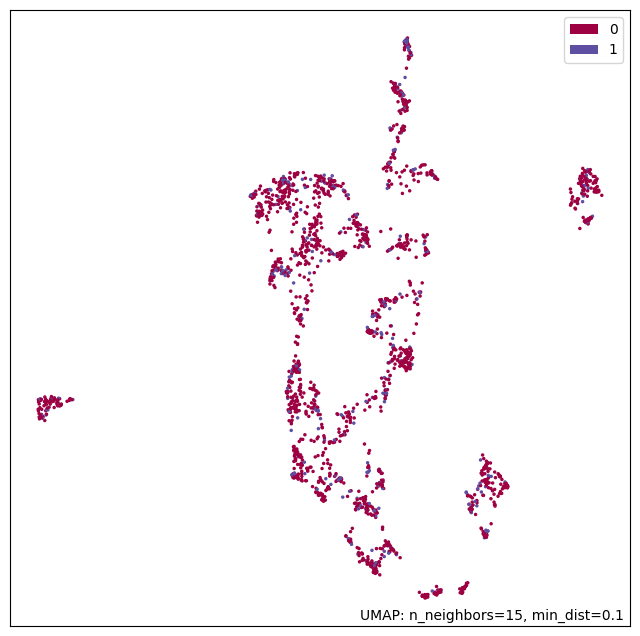

In [14]:
# Color by label array
import umap.plot
import umap
train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
mapper = umap.UMAP().fit(train_repr)
umap.plot.points(mapper, labels=train_labels)

# Pretty disappointing. 

In [15]:
test_repr_test = model.encode(test_data, encoding_window='multiscale' if all_labels.ndim == 1 else None)
test_repr_test = test_repr_test.reshape(len(test_data), -1)
test_repr_test.shape

(870, 3840000)

<Axes: >

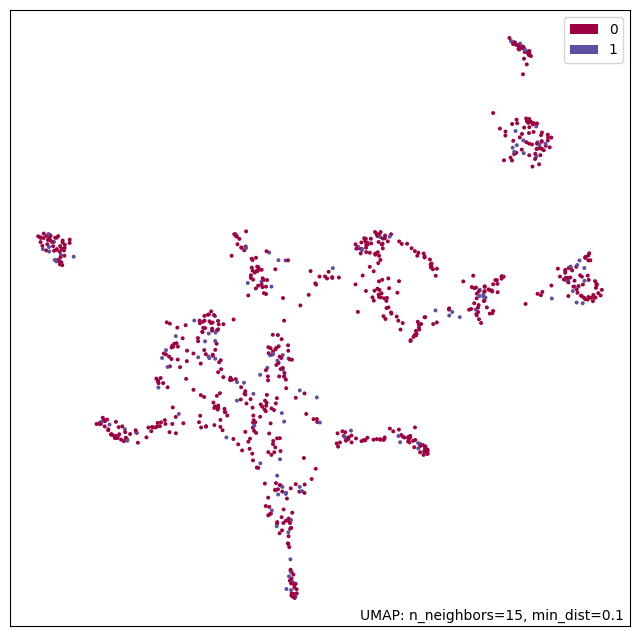

In [16]:
mapper = umap.UMAP().fit(test_repr_test)
umap.plot.points(mapper, labels=test_labels)

In [20]:
test_data.shape

(870, 600, 8)

In [16]:
test_repr_test.shape
# Batch size 600, length of the data is 600, at each timestamp there are 6400 features

(600, 600, 6400)

In [13]:
train_repr

array([[ 0.18986219, -0.0028137 ,  0.22311127, ...,  0.29875156,
         0.33047608,  0.1450717 ],
       [ 0.11926375, -0.0028137 ,  0.37648934, ...,  0.29875156,
         0.33047608,  0.1450717 ],
       [-0.00997572, -0.0028137 ,  0.43277338, ...,  0.29875156,
         0.33047608,  0.38952705],
       ...,
       [ 0.02469028,  0.07179785,  0.35504857, ...,  0.1479204 ,
         0.17254491,  0.03393582],
       [ 0.01968449,  0.23584604,  0.40573424, ...,  0.29875156,
         0.3572148 ,  0.4965966 ],
       [ 0.07292787,  0.05179311,  0.28284156, ...,  0.29875156,
         0.33047608,  0.2873893 ]], dtype=float32)